# Machine Learning technique on the PET block detector development - Part 1 (v1.0, 2019-05)
---
  
## 1. Introduction
  
  PET 

## load 2d map previously generated by the data acquistion software
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib

import time

In [2]:
plt.rcParams['figure.dpi'] = 150 # default is 72

###  
### Testing, load lookup table file first. The lookup table is 1024 by 1024 with big-endian 32 unsigned integer. 
---

In [3]:
file = "D:\\ML on PET block\\16x16_38mm_tof_block\\16x16\\15mm\\16x16x15_39mmPMT_Mask19_2011-11-29.lut"

In [4]:
# twoD_map_datatype 
# big endian using '>'
twoD_map_datatype = np.dtype('>u4')

In [5]:
lut = np.fromfile(file, dtype=twoD_map_datatype).reshape((1024,1024))

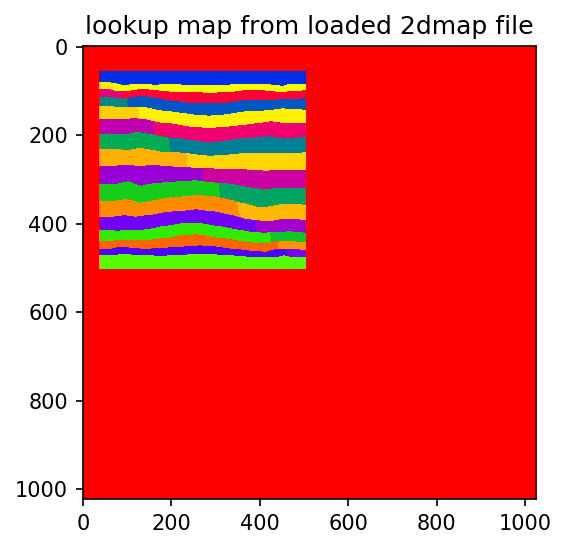

In [6]:
fig1 = plt.imshow(lut, cmap='prism')
plt.title('lookup map from loaded 2dmap file')
plt.savefig(".\\figs\\lut_from_lut_file.png", dpi=300)

### Load 2d map file. The 2d map is 1024 by 1024 with big-endian 32 unsigned integer, with a head of 16384 bytes for the spectrum (4096 4-byte integers).
---

In [7]:
file = "D:\\ML on PET block\\16x16_38mm_tof_block\\16x16\\15mm\\16x16x15_39mmPMT_Mask19_2011-11-29_map.dat"

In [8]:
data2 = np.fromfile(file, dtype=twoD_map_datatype)
spectrum = data2[0:4096]

In [9]:
spectrum

array([109634,  26014,  23725, ...,      0,      0,      0], dtype=uint32)

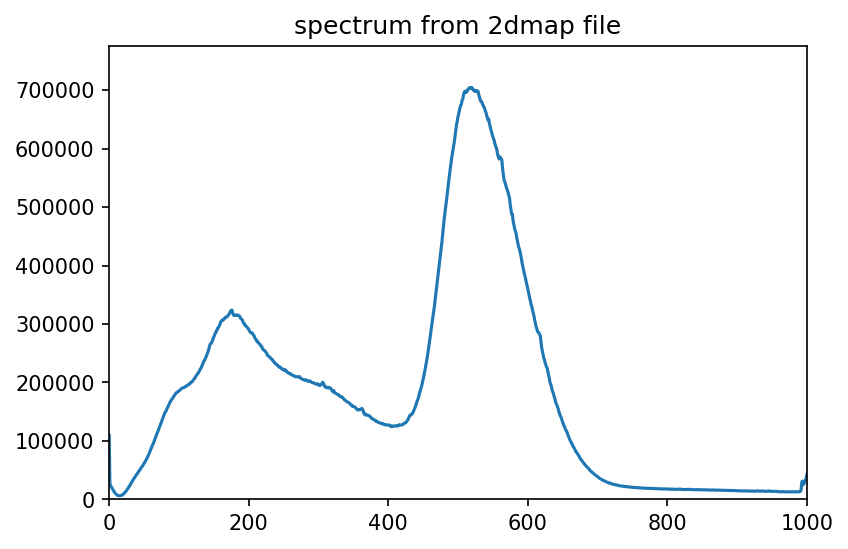

In [10]:
fig2, ax2 = plt.subplots()
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, max(spectrum[0:1000])*1.1)
ax2.plot(spectrum)
ax2.set_title("spectrum from 2dmap file")
plt.savefig(".\\figs\\spec_from_2dmap_file.png", dpi=300)

In [11]:
twoDMap = data2[4096:].reshape((1024,1024))

In [12]:
twoDMap.shape

(1024, 1024)

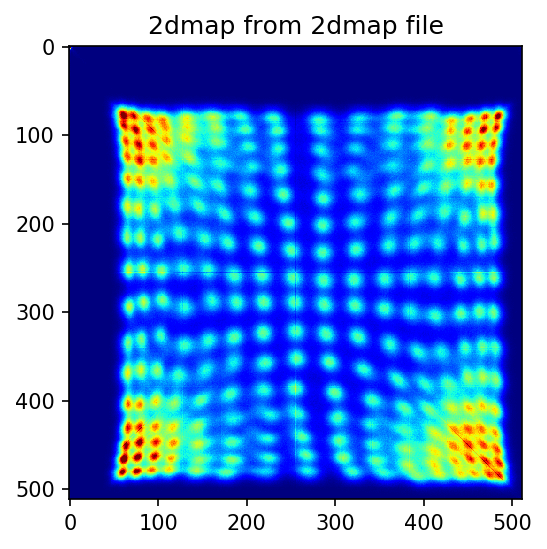

In [13]:
plt.imshow(twoDMap[0:512,0:512], vmax = 2000, cmap='jet')
plt.title("2dmap from 2dmap file")
plt.savefig(".\\figs\\2dmap_from_2dmap.png", dpi=300)

In [14]:
# plt.hist(data2[4096:], bins=500)

In [15]:
map_range_row_begin = 50
map_range_row_end = 511
map_range_col_begin = 30
map_range_col_end = 511


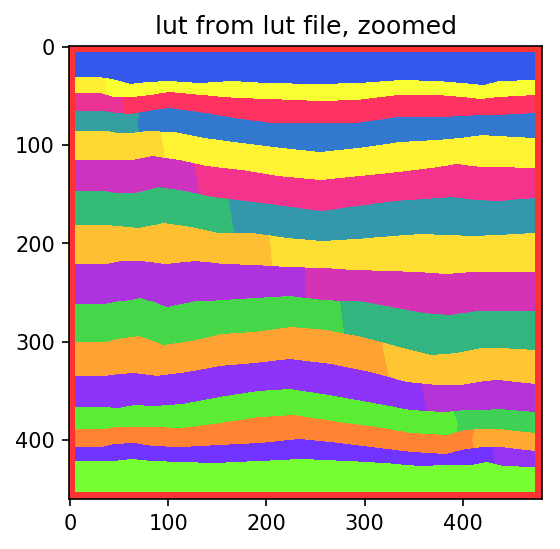

In [16]:
plt.imshow(lut[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="prism", alpha=0.8)
plt.title("lut from lut file, zoomed")
plt.savefig(".\\figs\\lut_from_lut_file_zoomed.png", dpi=300)

##  
## Generate the grid that seperates each detector pixel from the 2d map lut data.
---

In [17]:
def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

#     for i in range(512):
#         for j in range(512):
    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

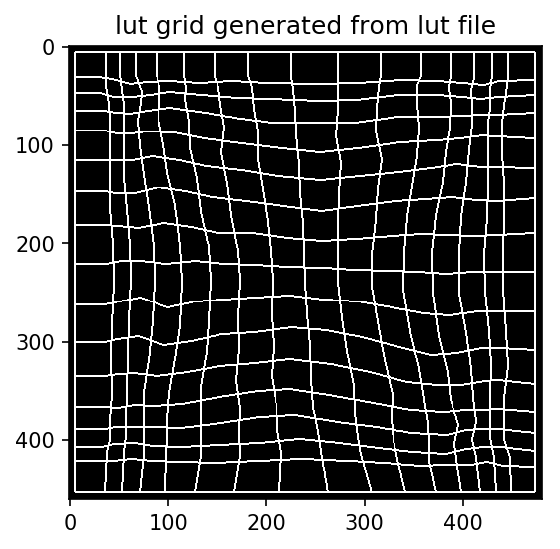

In [18]:
lut_grid = generate_grid(lut)

plt.imshow(lut_grid[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="gray")
plt.title("lut grid generated from lut file")
# plt.imsave("lut_grid.png",lut_grid,cmap="gray")
plt.savefig(".\\figs\\lut_grid_generated_from_lut_file.png", dpi=300)

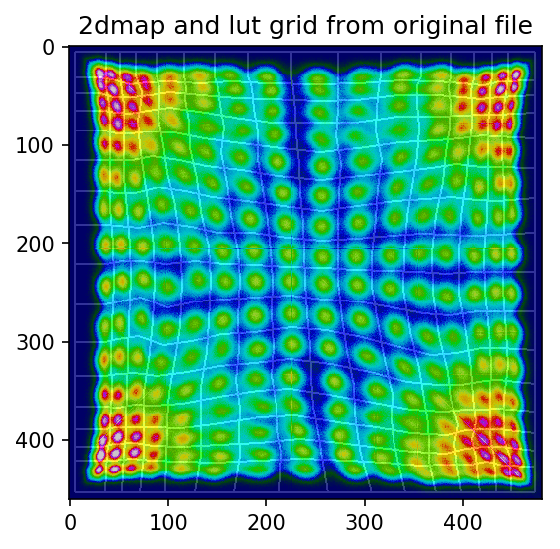

In [19]:
plt.imshow(twoDMap[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], vmax = 2000, cmap='gist_ncar')
plt.imshow(lut_grid[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="gray", alpha=0.2)
plt.title("2dmap and lut grid from original file")
plt.savefig(".\\figs\\2dmap_and_lut_grid_from_original_file.png", dpi=300)

In [20]:
lut_unique, lut_idx = np.unique(lut, return_inverse = True)

In [21]:
lut_unique

array([    0,  1001,  1002,  1003,  1004,  1005,  1006,  1007,  1008,
        1009,  1010,  1011,  1012,  1013,  1014,  1015,  1016,  2001,
        2002,  2003,  2004,  2005,  2006,  2007,  2008,  2009,  2010,
        2011,  2012,  2013,  2014,  2015,  2016,  3001,  3002,  3003,
        3004,  3005,  3006,  3007,  3008,  3009,  3010,  3011,  3012,
        3013,  3014,  3015,  3016,  4001,  4002,  4003,  4004,  4005,
        4006,  4007,  4008,  4009,  4010,  4011,  4012,  4013,  4014,
        4015,  4016,  5001,  5002,  5003,  5004,  5005,  5006,  5007,
        5008,  5009,  5010,  5011,  5012,  5013,  5014,  5015,  5016,
        6001,  6002,  6003,  6004,  6005,  6006,  6007,  6008,  6009,
        6010,  6011,  6012,  6013,  6014,  6015,  6016,  7001,  7002,
        7003,  7004,  7005,  7006,  7007,  7008,  7009,  7010,  7011,
        7012,  7013,  7014,  7015,  7016,  8001,  8002,  8003,  8004,
        8005,  8006,  8007,  8008,  8009,  8010,  8011,  8012,  8013,
        8014,  8015,

In [22]:
lut_idx

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
lut_1 = lut_idx.reshape((1024,1024))

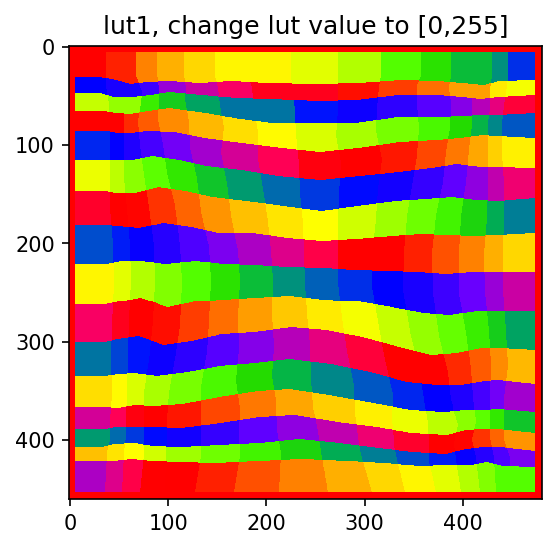

In [24]:
# plt.imshow(lut_1, cmap='prism')
plt.imshow(lut_1[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="prism")
plt.title("lut1, change lut value to [0,255]")
plt.savefig(".\\figs\\lut_1.png", dpi=300)

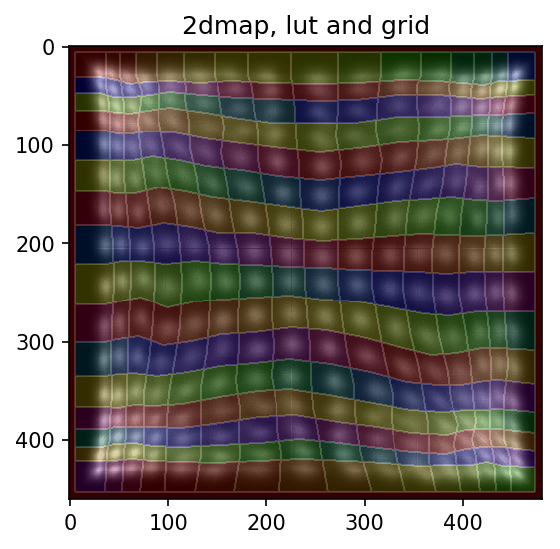

In [25]:
plt.imshow(twoDMap[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], vmax = 2000, cmap='gray')
plt.imshow(lut_grid[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="gray", alpha=0.2)
plt.imshow(lut_1[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="prism", alpha=0.2)
plt.title("2dmap, lut and grid")
plt.savefig(".\\figs\\2dmap_lut_and_grid.png", dpi=300)

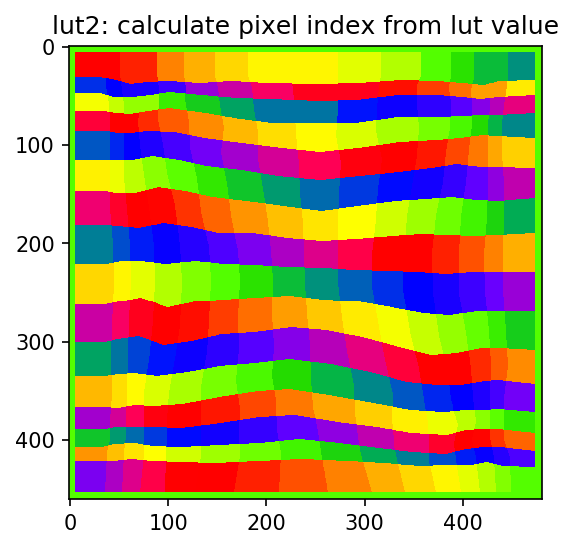

In [26]:
# get pixel index from lut, index_y=lut[i]/1000-1, index_x=lut[i]%1000-1
# pixel index = index_x * block_dimension + index_y

block_dimension = 16

# lut_2 = np.zeros(lut.shape)
index_y = np.floor_divide(lut,1000)-1
index_x = np.remainder(lut,1000) - 1
lut_2 = index_y * block_dimension + index_x
lut_2[lut_2>=256] = 256

plt.imshow(lut_2[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap="prism")
plt.title("lut2: calculate pixel index from lut value")
plt.savefig(".\\figs\\lut_2.png", dpi=300)


In [27]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

Number of labels: 257


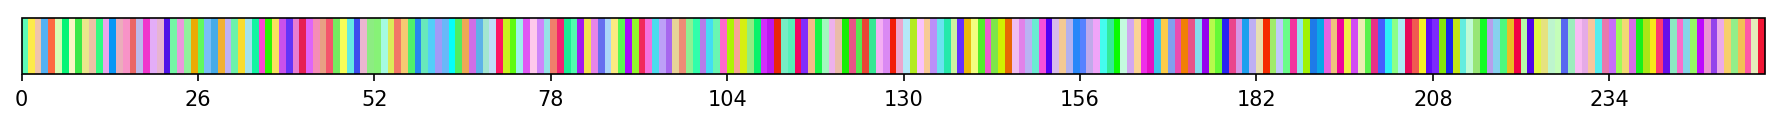

In [28]:
new_cmap = rand_cmap(257, type='bright', first_color_black=False, last_color_black=False, verbose=True)

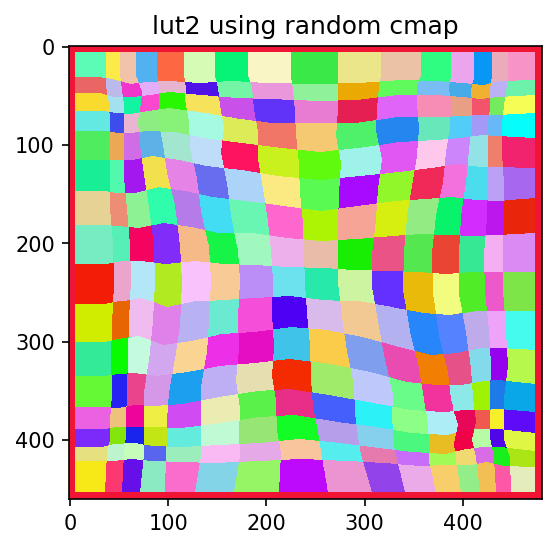

In [29]:
plt.imshow(lut_2[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap=new_cmap)
plt.title("lut2 using random cmap")
plt.savefig(".\\figs\\lut_2_random_cmap.png", dpi=300)

In [30]:
# reference
# https://photutils.readthedocs.io/en/stable/_modules/photutils/utils/colormaps.html#random_cmap

from sklearn.utils import check_random_state

def random_cmap(ncolors=256, random_state=None):
    """
    Generate a matplotlib colormap consisting of random (muted) colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    """

    from matplotlib import colors

    prng = check_random_state(random_state)
    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.4, high=0.9, size=ncolors)
    v = prng.uniform(low=0.7, high=1.0, size=ncolors)
    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)

In [31]:
new_cmap1 = random_cmap()

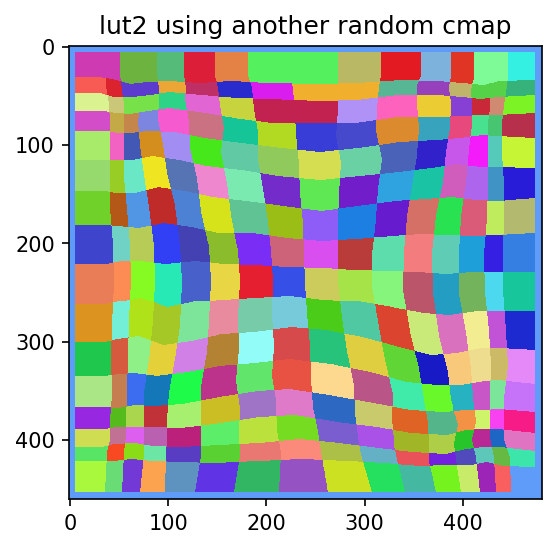

In [32]:
plt.imshow(lut_2[map_range_row_begin:map_range_row_end, map_range_col_begin:map_range_col_end], cmap=new_cmap1)
plt.title("lut2 using another random cmap")
plt.savefig(".\\figs\\lut_2_random_cmap1.png", dpi=300)


##  
## Load raw data and generate the 2d map
---

In [33]:
file = "D:\\ML on PET block\\16x16_38mm_tof_block\\16x16\\15mm\\16x16x15_39mmPMT_Mask19_Nov.29.2011_raw.dat"
data = np.fromfile(file, dtype=np.dtype('<u4'))
print(data.shape)

(62582784,)


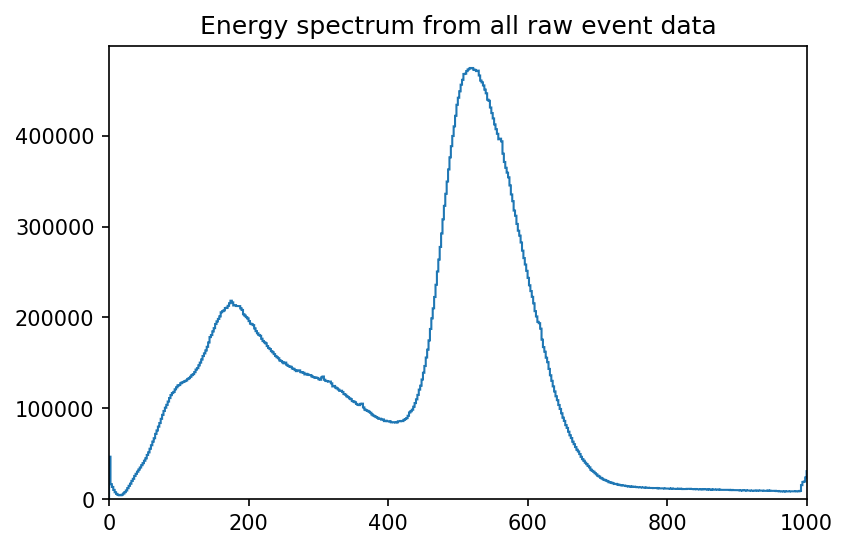

In [34]:
# create energy spectrum from all event data

E0 = np.right_shift(np.bitwise_and(data, 0xFFF00000), 20)

fig, ax = plt.subplots()
ax.set_xlim(0, 1000)
plt.hist(E0, bins=512, range=(0,1024), histtype = 'step')
ax.set_title("Energy spectrum from all raw event data")
plt.savefig(".\\figs\\Energy_spectrum_from_raw_data.png", dpi=300)

In [35]:
# set low and high Energy threshold for x and y computation

E_th_low = 400
E_th_high = 800

E_1 = (E0 > E_th_low) & (E0 < E_th_high)

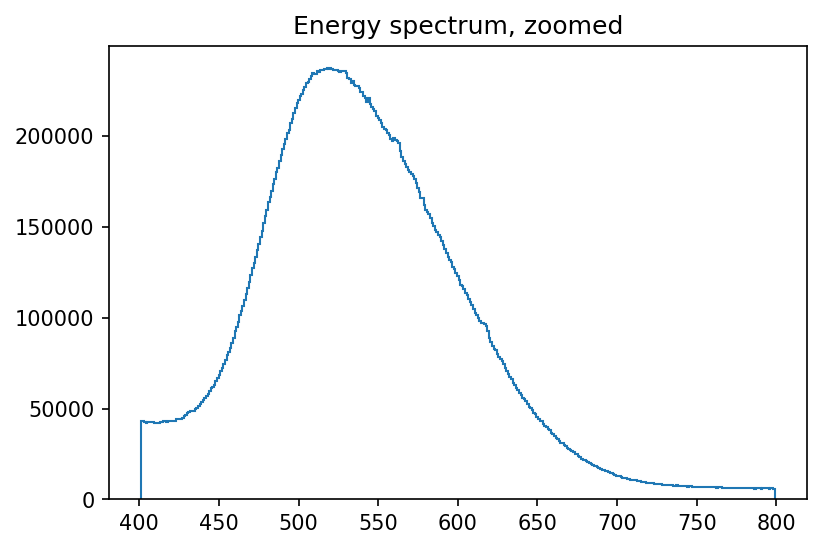

In [36]:
Ey = (np.right_shift( np.bitwise_and(data, 0x000FFC00), 10))[E_1]
Ex = (np.bitwise_and(data, 0x000003FF))[E_1]
E1 = E0[E_1]

fig = plt.hist(E1, bins=399, histtype='step')
plt.title('Energy spectrum, zoomed')
plt.savefig('.\\figs\\Energy_spectrum_from_raw_data_zoomed.png', dpi=300)

In [37]:
x = (1 - Ex/E1) * 512
y = (1 - Ey/E1) * 512

In [38]:
# plt.scatter(x[0:100000],y[0:100000], s=1,marker='.')
# plt.xlim(0,1024)
# plt.ylim(0,1024)

In [39]:
histgram2d, xedges, yedges = np.histogram2d(x, y, bins=512, range=[[0,512],[0,512]])

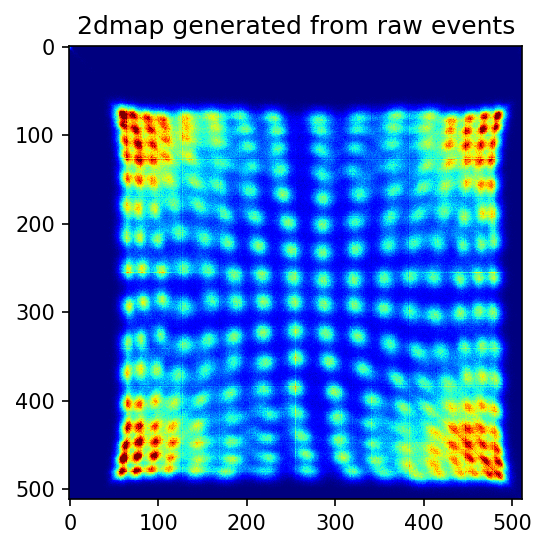

In [40]:
plt.imshow(histgram2d, vmax=600, cmap='jet')
plt.title('2dmap generated from raw events')
plt.savefig(".//figs//2dmap_from_raw_data.png", dpi=300)

##  
## Using Machine Learing technique to generate the lookuptable
---

- K-Means clustring using raw data events
---

In [41]:
from sklearn.cluster import KMeans

In [42]:
# number of detector pixels: N, which is the number of clusters here
N = 256
input_data = np.stack((x,y), axis=1)[:256000]

In [43]:
# fit or load previous fitted model

FLAG_LOAD = True

if FLAG_LOAD:
    with open('.//models//kmeans1.pkl', 'rb') as fin:
        kmeans1 = pickle.load(fin)
else:
    kmeans1 = KMeans(n_clusters = N, init = 'k-means++', random_state = 1)
    kmeans1.fit(input_data)

    # save trained model to a file
    with open('.//models//kmeans1.pkl', 'wb') as fout:
        pickle.dump(kmeans1, fout)

    joblib.dump(kmeans1, './/models//kmeans1.joblib')


In [44]:
print(kmeans1.inertia_)

27494813.927116267


In [45]:
grid_x, grid_y = np.meshgrid(np.arange(start=0, stop=512, step=1), \
                             np.arange(start=0, stop=512, step=1))

In [46]:
# fit input using 2dmap as the sample_weight
fit_input = np.array([grid_x.ravel(), grid_y.ravel()]).T

with open('.//models//fit_input.pkl', 'wb') as fout:
    pickle.dump(fit_input, fout)

In [47]:
lut_kmeans1 = kmeans1.predict(np.array([grid_x.ravel(), grid_y.ravel()]).T).reshape(grid_x.shape)

In [48]:
lut_kmeans1

array([[ 64,  64,  64, ...,  12,  12,  12],
       [ 64,  64,  64, ...,  12,  12,  12],
       [ 64,  64,  64, ...,  12,  12,  12],
       ...,
       [200, 200, 200, ...,  42,  42,  42],
       [200, 200, 200, ...,  42,  42,  42],
       [200, 200, 200, ...,  42,  42,  42]])

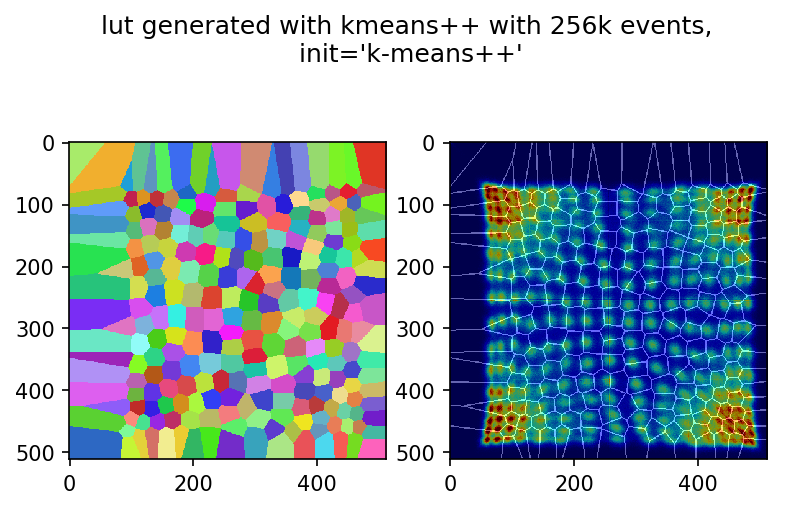

In [49]:
fig, axis = plt.subplots(1,2)

axis[0].imshow(lut_kmeans1, cmap=new_cmap1)
axis[1].imshow(histgram2d, vmax=600, cmap='jet')
axis[1].imshow(generate_grid(lut_kmeans1), cmap='gray', alpha=0.4)

fig.suptitle("lut generated with kmeans++ with 256k events,\n init='k-means++'")

plt.savefig(".//figs//kmeans1_from_raw_events.png", dpi=300)

- Using 2dmap as input with sample_weight
---

In [50]:
# t0 = time.time()

# kmeans2 = KMeans(n_clusters = N, init = 'k-means++', random_state = 1)
# kmeans2.fit(fit_input, sample_weight = histgram2d.ravel())
# print(kmeans2.inertia_)

# t1 = time.time()
# print('running time: {0:0.3f}'.format(t1-t0),'sec')

# # running time: 2404.516 sec

In [51]:
# # save trained model to a file
# with open('.//models//kmeans2.pkl', 'wb') as fout:
#     pickle.dump(kmeans2, fout)


In [52]:
# fit or load previous fitted model

FLAG_LOAD = True

if FLAG_LOAD:
    with open('.//models//kmeans2.pkl', 'rb') as fin:
        kmeans2 = pickle.load(fin)
else:
    t0 = time.time()

    kmeans2 = KMeans(n_clusters = N, init = 'k-means++', random_state = 1)
    kmeans2.fit(fit_input, sample_weight = histgram2d.ravel())
    print(kmeans2.inertia_)

    t1 = time.time()
    print('running time: {0:0.3f}'.format(t1-t0),'sec')

    # save trained model to a file
    with open('.//models//kmeans2.pkl', 'wb') as fout:
        pickle.dump(kmeans2, fout)

    joblib.dump(kmeans2, './/models//kmeans2.joblib')
    
# running time: 2404.516 sec

In [53]:
lut_kmeans2 = kmeans2.predict(fit_input).reshape(grid_x.shape)

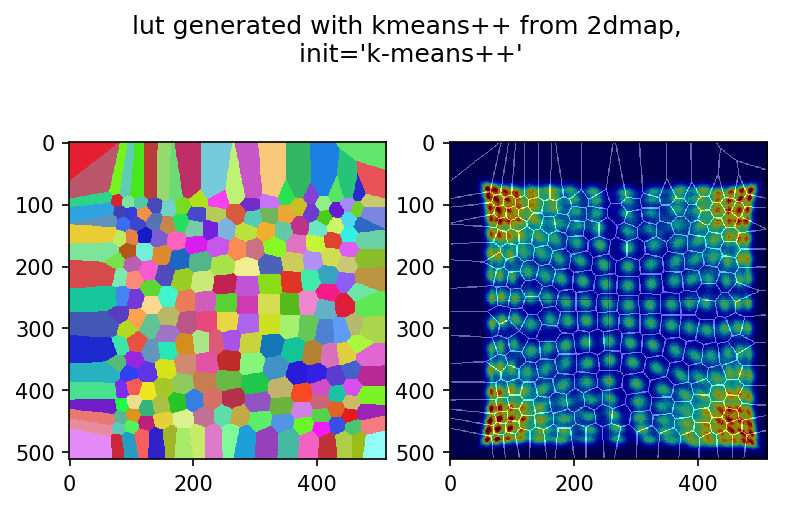

In [54]:
fig, axis = plt.subplots(1,2)
axis[0].imshow(lut_kmeans2, cmap=new_cmap1)
axis[1].imshow(histgram2d, vmax=600, cmap='jet')
axis[1].imshow(generate_grid(lut_kmeans2), cmap='gray', alpha=0.4)

fig.suptitle("lut generated with kmeans++ from 2dmap,\n init='k-means++'")
plt.savefig(".//figs//kmeans2_from_2dmap_no_init.png", dpi=300)


- Using grid coordinates as the initial position
---

In [55]:
# initial cluster positions, uniform distributed grid

ini_x, ini_y = np.meshgrid(np.arange(start=15, stop=512-16, step=32), np.arange(start=1, stop=512-16, step=32))
init_input = np.array([ini_x.ravel(), ini_y.ravel()]).T

In [56]:
# kmeans3 = KMeans(n_clusters = N, init = init_input, random_state = 1)
# kmeans3.fit(fit_input, sample_weight = histgram2d.ravel())
# print(kmeans3.inertia_)

# fit or load previous fitted model

FLAG_LOAD = True

if FLAG_LOAD:
    with open('.//models//kmeans3.pkl', 'rb') as fin:
        kmeans3 = pickle.load(fin)
else:
    t0 = time.time()

    kmeans3 = KMeans(n_clusters = N, init = init_input, random_state = 1)
    kmeans3.fit(fit_input, sample_weight = histgram2d.ravel())
    print(kmeans3.inertia_)

    t1 = time.time()
    print('running time: {0:0.3f}'.format(t1-t0),'sec')

    # save trained model to a file
    with open('.//models//kmeans3.pkl', 'wb') as fout:
        pickle.dump(kmeans3, fout)

    joblib.dump(kmeans3, './/models//kmeans3.joblib')

#     running time: 269.419 sec

In [57]:
lut_kmeans3 = kmeans3.predict(fit_input).reshape(grid_x.shape)

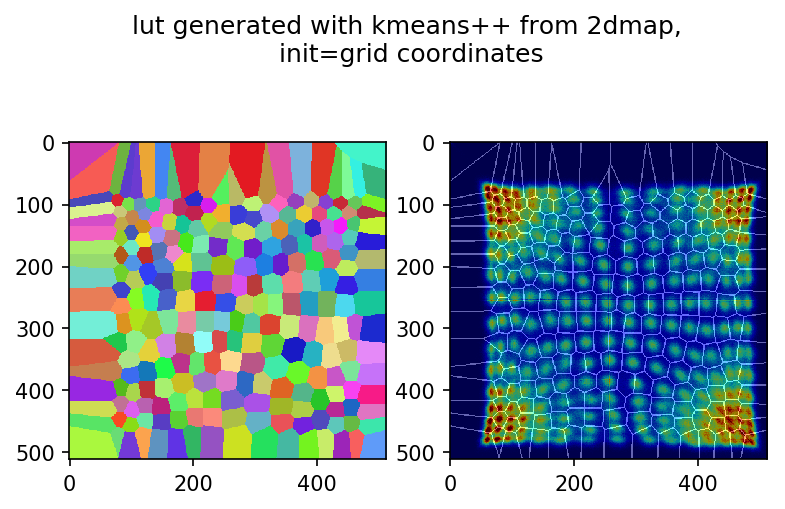

In [58]:
fig, axis = plt.subplots(1,2)
axis[0].imshow(lut_kmeans3, cmap=new_cmap1)
axis[1].imshow(histgram2d, vmax=600, cmap='jet')
axis[1].imshow(generate_grid(lut_kmeans3), cmap='gray', alpha=0.4)
fig.suptitle("lut generated with kmeans++ from 2dmap,\n init=grid coordinates")
plt.savefig(".//figs//kmeans3_from_2dmap_grid_init.png", dpi=300)

##  
## Using imaing processing method finding the peak positions first
---

In [59]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

In [60]:
map_fltd = ndi.gaussian_filter(histgram2d, sigma=0.75, mode='constant')

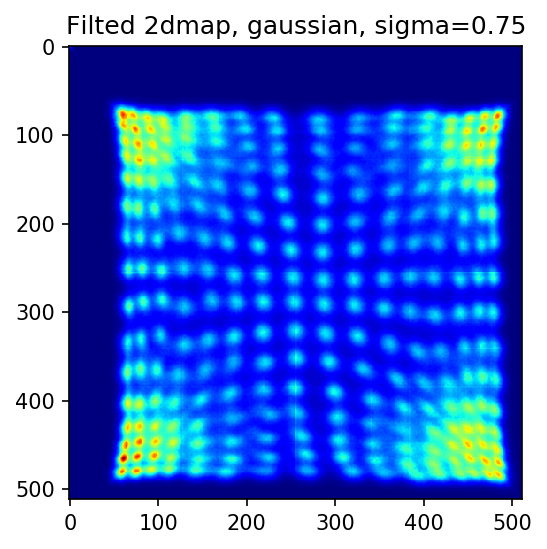

In [61]:
plt.imshow(map_fltd, cmap='jet')
plt.title("Filted 2dmap, gaussian, sigma=0.75")
plt.savefig(".\\figs\\Filted_2dmap.png", dpi=300)

## Peak data format: [row, column]!

In [179]:
peaks = peak_local_max(histgram2d, threshold_abs =200, num_peaks = 256, min_distance=20)
peaks0 = np.copy(peaks)
peaks0[:,0] = peaks[:,1]
peaks0[:,1] = peaks[:,0]
print(peaks0.shape)

(128, 2)


In [180]:
peaks = peak_local_max(map_fltd, threshold_abs =200, num_peaks = 256, min_distance=5)
peaks1 = np.copy(peaks)
peaks1[:,0] = peaks[:,1]
peaks1[:,1] = peaks[:,0]
print(peaks1.shape)

(256, 2)


In [183]:
fig, axes = plt.subplots(1,2)

im1 = axes[0].imshow(histgram2d, cmap='jet')
axes[0].plot(peaks0[:,0], peaks0[:,1], 'r+', markersize=3, markeredgewidth=.5)
fig.colorbar(im1, ax=axes[0], shrink = 0.5)
axes[0].set_title("original 2dmap")

im2 = axes[1].imshow(map_fltd, cmap='jet')
axes[1].plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=3, markeredgewidth=.5)
fig.colorbar(im2, ax=axes[1], shrink = 0.5)
axes[1].set_title("filtered 2dmap")

plt.savefig(".//figs//Auto_selected_peaks_from_2dmap.png", dpi=600)

##  
### switch to interactive mode to modify the selected peaks

In [184]:
%matplotlib qt
# %matplotlib inline
# %matplotlib notebook

In [198]:
# peaks0: from original 2dmap
# peaks1: from filtered 2dmap


from scipy.spatial import distance

def add_peak_to_list(peak_x, peak_y):
    
    global peaks1
    
    X = [(round(peak_x), round(peak_y))]
    peaks1 = np.append(peaks1, X, axis=0)
    
    print ('Add peak', X, 'to peaks1 list. Number of peak is' ,peaks1.shape[0])
    return True


In [186]:
peaks1.argmin()

24

In [ ]:
def remove_peak_from_list(peak_x, peak_y, min_dist=5):
    
    global peaks1
    
    X = [(round(peak_x), round(peak_y))]
    d2 = distance.cdist(X, peaks1, metric='euclidean')[0,:]
#     print('distance=',d2)
    
    p_remove_index = d2.argmin()
    d_min = d2.min()
    
    if d_min > min_dist:
        print ('No peak within minimum distance of', min_dist,'.')
        return False
    
    print('min distance=',d2[p_remove_index],' index=',p_remove_index)
    
    print ('Peak at', peaks1[p_remove_index],'near selected point',X, \
           'with distance of', d_min, 'is being removed.')
    
    peaks1 =  np.delete(peaks1,p_remove_index,axis=0)
    print ('Number of peak left', peaks1.shape[0])
    return True


In [ ]:
fig_i, axes = plt.subplots()

im1 = axes.imshow(histgram2d, cmap='jet')
axes.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=15, markeredgewidth=2)

pos = []

class key:

    def __init__(self):
        self.shift_is_held = False
        self.ctrl_is_held = False

key_stat = key()
        
def on_key_press(event):
# def on_key_press(event, key_stat):
#     print('key = %s, pressed' % event.key)
    global key_stat
    
    if 'shift' in event.key:
        key_stat.shift_is_held = True
    if 'control' in event.key:
        key_stat.ctrl_is_held = True
        
        
def on_key_release(event):
# def on_key_release(event, key_stat):
#     print('key = %s, releaseed' % event.key)
    global key_stat

    if 'shift' in event.key:
        key_stat.shift_is_held = False    
    if 'control' in event.key:
        key_stat.ctrl_is_held = False

        
def onclick(event):
# def onclick(event, key_stat):
    global key_stat
    global axes, peaks1, fig_i

    ret = False
    
#     print('%s click: button=%d,x=%d, y=%d, xdata=%f, ydata=%f' %
#           ('double' if event.dblclick else 'single', event.button, 
#            event.x, event.y, event.xdata, event.ydata))
    
#     print('shift down =', key_stat.shift_is_held, '; ctrl down =', key_stat.ctrl_is_held)
    
    if key_stat.shift_is_held and not key_stat.ctrl_is_held:
#         print('shift key pressed only')
        ret = add_peak_to_list(event.xdata, event.ydata)
        print('ret=',ret)
        
    if key_stat.ctrl_is_held and not key_stat.shift_is_held:
#         print('control key pressed only')
        ret = remove_peak_from_list(event.xdata, event.ydata)
    
    if ret:
#         update_graph
        print('Peak num',peaks1.shape[0]) 
        axes.clear()
        axes.imshow(histgram2d, cmap='jet')
        axes.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=15, markeredgewidth=2)
        plt.draw()
        ret = False
        
    
        
# cid_kye_p = fig_i.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, key_stat) )
# cid_key_r = fig_i.canvas.mpl_connect('key_release_event', lambda event: on_key_release(event, key_stat) )
# cid_mouse_press = fig_i.canvas.mpl_connect('button_press_event', lambda event: onclick(event, key_stat) )
cid_kye_p = fig_i.canvas.mpl_connect('key_press_event', on_key_press)
cid_key_r = fig_i.canvas.mpl_connect('key_release_event', on_key_release)
cid_mouse_press = fig_i.canvas.mpl_connect('button_press_event', onclick)
        
fig_i.show()


* save peak positions and 2dmap with peaks

In [206]:
with open('.//models//peak_positions.pkl', 'wb') as fout:
        pickle.dump(peaks1, fout)

joblib.dump(peaks1, './/models//peak_positions.joblib')


['.//models//peak_positions.joblib']

In [229]:
%matplotlib inline
# %matplotlib notebook
plt.rcParams['figure.dpi'] = 150


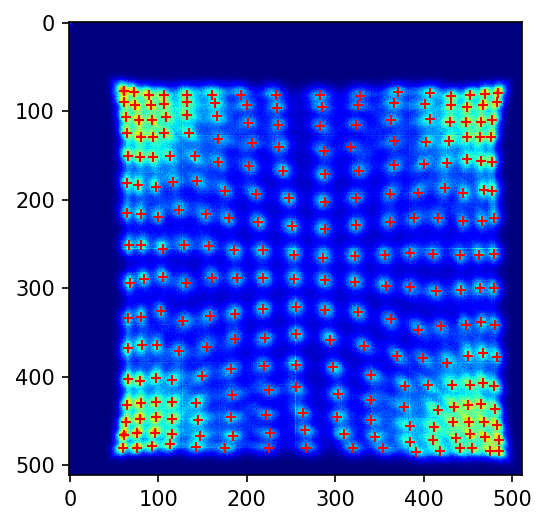

In [232]:
fig_i, axes = plt.subplots()

im1 = axes.imshow(histgram2d, cmap='jet')
axes.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=5, markeredgewidth=1)
plt.savefig(".//figs//2dmap_with_peaks.png", dpi=300)

In [207]:
FLAG_LOAD = True

if FLAG_LOAD:
    with open('.//models//kmeans4.pkl', 'rb') as fin:
        kmeans4 = pickle.load(fin)
else:
    t0 = time.time()

    kmeans4 = KMeans(n_clusters = N, init = peaks1, random_state = 1, n_init=1)
    kmeans4.fit(fit_input, sample_weight = histgram2d.ravel())
    print(kmeans4.inertia_)

    t1 = time.time()
    print('running time: {0:0.3f}'.format(t1-t0),'sec')

    # save trained model to a file
    with open('.//models//kmeans4.pkl', 'wb') as fout:
        pickle.dump(kmeans4, fout)

    joblib.dump(kmeans4, './/models//kmeans3.joblib')

#     running time: 131.217 sec

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


27890286.185193848
running time: 131.217 sec


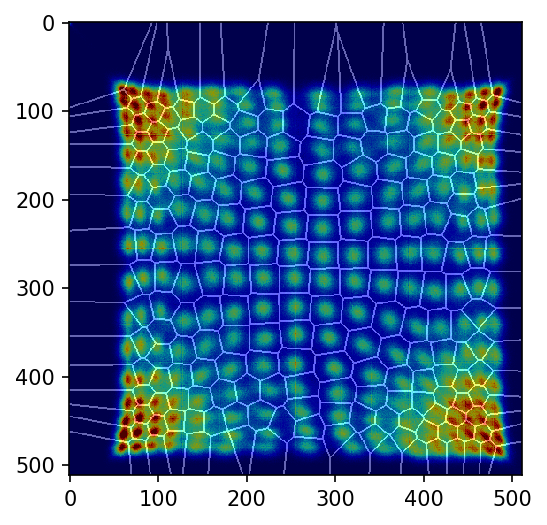

In [243]:
lut_kmeans4 = kmeans4.predict(np.array([grid_x.ravel(), grid_y.ravel()]).T).reshape(grid_x.shape)
plt.imshow(histgram2d, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4), cmap='gray', alpha=0.4)
filename = ".//figs//2dmap_with_grid_from_kmeans4_iter=" + str(kmeans4.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

##  
## One iteration only in kmeans clustering

In [282]:
# one iteration only
t0 = time.time()

kmeans4_a = KMeans(n_clusters = N, init = peaks1, random_state = 1, n_init=1, max_iter = 1)
kmeans4_a.fit(fit_input, sample_weight = histgram2d.ravel())
print("kmeans4_a.inertia_=",kmeans4_a.inertia_)

t1 = time.time()
print('running time: {0:0.3f}'.format(t1-t0),'sec')

# kmeans4_a.inertia_=29191928.48443837
# running time: 2.250 sec

kmeans4_a.inertia_= 29191928.48443837
running time: 2.297 sec


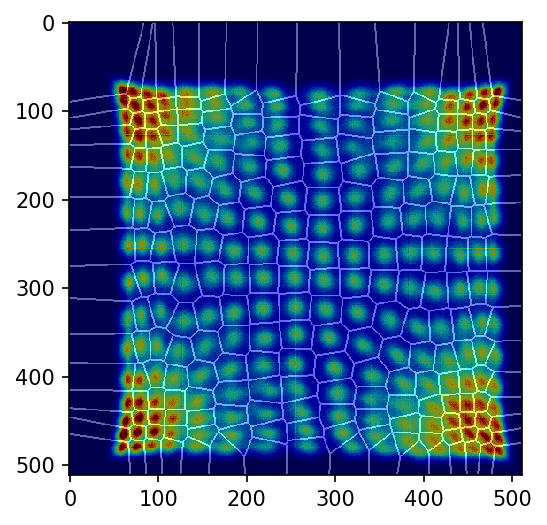

In [380]:
lut_kmeans4_a = kmeans4_a.predict(np.array([grid_x.ravel(), grid_y.ravel()]).T).reshape(grid_x.shape)
plt.imshow(histgram2d, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_a), cmap='gray', alpha=0.4)
filename = ".//figs//2dmap_with_grid_from_kmeans4a_iter=" + str(kmeans4_a.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

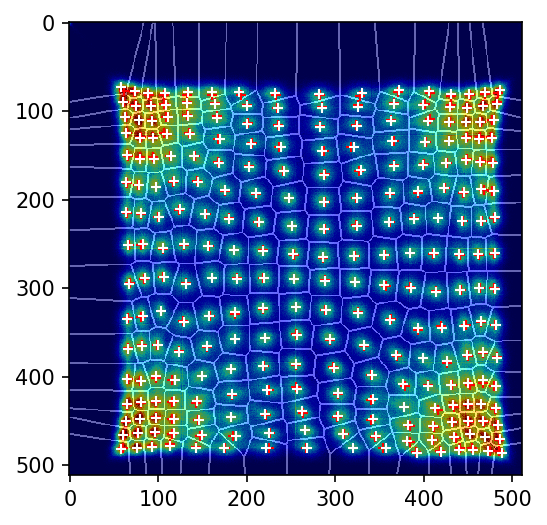

In [378]:
plt.imshow(histgram2d, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_a), cmap='gray', alpha=0.4)
plt.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=5, markeredgewidth=1)

plt.plot(kmeans4_a.cluster_centers_[:,0], kmeans4_a.cluster_centers_[:,1],'w+', markersize=5, markeredgewidth=1)
plt.show

filename = ".//figs//2dmap_with_grid_and_peaks_from_kmeans4a_iter=" + str(kmeans4_a.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

##  
## Scale up (100x) the peak value to lock the pre-defined the center point of each cluster

In [361]:
scale_factor = 100

peak_index = np.int16(peaks1)

histgram2d_rescale = np.copy(histgram2d)
histgram2d_rescale[[peak_index[:,1]],[peak_index[:,0]]] = histgram2d[[peak_index[:,1]],[peak_index[:,0]]] * scale_factor


In [363]:
# one iteration only
t0 = time.time()

kmeans4_b = KMeans(n_clusters = N, init = peaks1, random_state = 1, n_init=1, max_iter = 1)
kmeans4_b.fit(fit_input, sample_weight = histgram2d_rescale.ravel())
print("kmeans4_b.inertia_=",kmeans4_b.inertia_)

t1 = time.time()
print('running time: {0:0.3f}'.format(t1-t0),'sec')

# kmeans4_b.inertia_= 22852682.55455224
# running time:  2.172 sec

kmeans4_b.inertia_= 22852682.55455224
running time: 2.172 sec


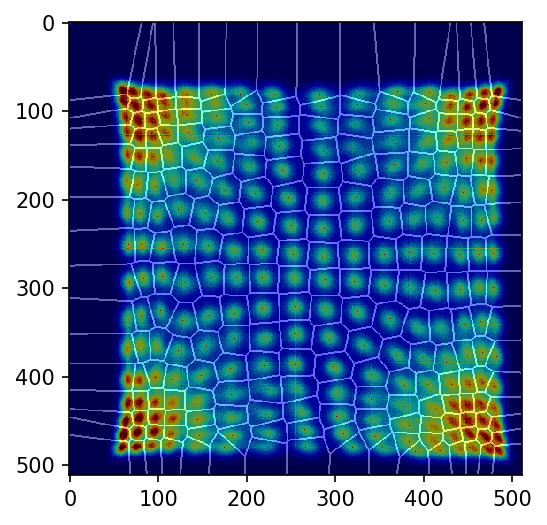

In [387]:
lut_kmeans4_b = kmeans4_b.predict(np.array([grid_x.ravel(), grid_y.ravel()]).T).reshape(grid_x.shape)
plt.imshow(histgram2d_rescale, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_b), cmap='gray', alpha=0.4)
plt.show

filename = ".//figs//2dmap_with_grid_from_kmeans4b_rescaled_iter=" + str(kmeans4_b.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

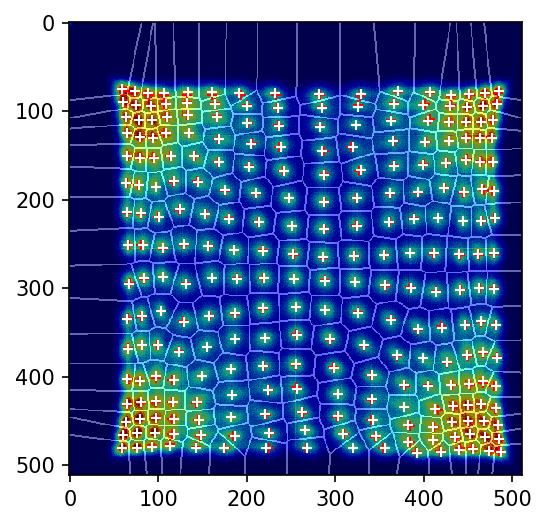

In [388]:
plt.imshow(histgram2d_rescale, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_b), cmap='gray', alpha=0.4)
plt.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=5, markeredgewidth=1)

plt.plot(kmeans4_b.cluster_centers_[:,0], kmeans4_b.cluster_centers_[:,1],'w+', markersize=5, markeredgewidth=1)
plt.show

filename = ".//figs//2dmap_with_grid_and_peaks_from_kmeans4b_rescaled_iter=" + str(kmeans4_b.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

In [384]:
# multiple iteration
t0 = time.time()

kmeans4_c = KMeans(n_clusters = N, init = peaks1, random_state = 1, n_init=1, max_iter = 5)
kmeans4_c.fit(fit_input, sample_weight = histgram2d_rescale.ravel())
print("kmeans4_c.inertia_=",kmeans4_c.inertia_)

t1 = time.time()
print('running time: {0:0.3f}'.format(t1-t0),'sec')

# kmeans4_c.inertia_= 
# running time:  sec

kmeans4_c.inertia_= 22701183.96738339
running time: 6.766 sec


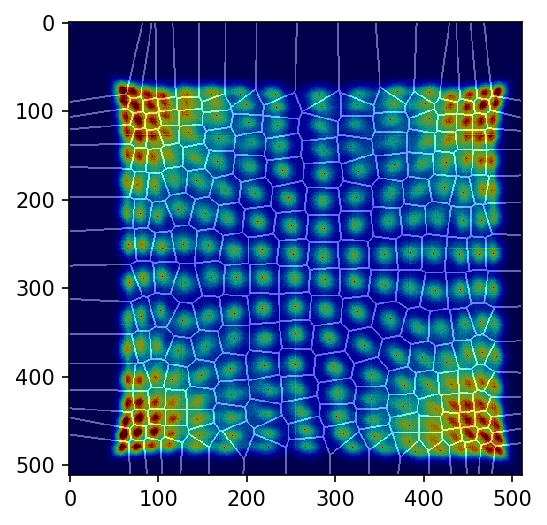

In [385]:
lut_kmeans4_c = kmeans4_c.predict(np.array([grid_x.ravel(), grid_y.ravel()]).T).reshape(grid_x.shape)
plt.imshow(histgram2d_rescale, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_c), cmap='gray', alpha=0.4)
plt.show

filename = ".//figs//2dmap_with_grid_from_kmeans4c_rescaled_iter=" + str(kmeans4_c.n_iter_) + ".png"
plt.savefig(filename, dpi=300)

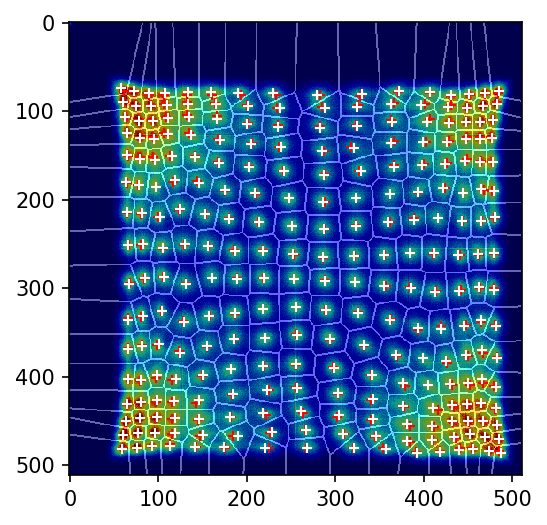

In [386]:
plt.imshow(histgram2d_rescale, vmax=600, cmap='jet')
plt.imshow(generate_grid(lut_kmeans4_c), cmap='gray', alpha=0.4)

plt.plot(peaks1[:,0], peaks1[:,1], 'r+', markersize=5, markeredgewidth=1)

plt.plot(kmeans4_c.cluster_centers_[:,0], kmeans4_c.cluster_centers_[:,1],'w+', markersize=5, markeredgewidth=1)
plt.show

filename = ".//figs//2dmap_with_grid_and_peaks_from_kmeans4c_rescaled_iter=" + str(kmeans4_c.n_iter_) + ".png"
plt.savefig(filename, dpi=300)